In [1]:
!nvidia-smi

Fri Jun 13 13:12:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   28C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!gdown -qqq 18jwp7X3wFoVTq75Y4ARjXbgFEVPUwOHm
!unzip -qq ocr-documents.zip

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq transformers==4.52.4 --progress-bar off
!pip install -qqq flash-attn==2.7.4.post1 --progress-bar off
!pip install -qqq rich==14.0.0 --progress-bar off

In [12]:
from PIL import Image
from transformers import AutoTokenizer, AutoProcessor, AutoModelForImageTextToText
from rich.console import Console
from rich.markdown import Markdown
import base64
from markdown import markdown
from IPython.display import display, HTML

In [5]:
model_path = "nanonets/Nanonets-OCR-s"

model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="flash_attention_2",
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)

config.json:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


video_preprocessor_config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

In [6]:
model

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionFlashAttention2(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): 

In [7]:
def ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=4096):
    prompt = """Extract the text from the above document as if you were reading it naturally. Return the tables in markdown format. Return the equations in LaTeX representation. If there is an image in the document and image caption is not present, add a small description of the image inside the <img></img> tag; otherwise, add the image caption inside <img></img>. Watermarks should be wrapped in brackets. Ex: <watermark>OFFICIAL COPY</watermark>. Page numbers should be wrapped in brackets. Ex: <page_number>14</page_number> or <page_number>9/22</page_number>. Prefer using ☐ and ☑ for check boxes."""
    image = Image.open(image_path)
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": f"file://{image_path}"},
                {"type": "text", "text": prompt},
            ],
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to(model.device)

    output_ids = model.generate(
        **inputs, max_new_tokens=max_new_tokens, do_sample=False
    )
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text[0]

In [8]:
%%time

image_path = "nvidia-first-page.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 1min 3s, sys: 455 ms, total: 1min 4s
Wall time: 1min 6s


In [13]:
console = Console()
console.print(Markdown(result))

NVIDIA logo                                                                                                        

NVIDIA Announces Financial Results for First Quarter Fiscal 2026                                                   

 • Revenue of $44.1 billion, up 12% from Q4 and up 69% from a year ago                                             
 • Data Center revenue of $39.1 billion, up 10% from Q4 and up 73% from a year ago                                 

NVIDIA (NASDAQ: NVDA) today reported revenue for the first quarter ended April 27, 2025, of $44.1 billion, up 12%  
from the previous quarter and up 69% from a year ago.                                                              

On April 9, 2025, NVIDIA was informed by the U.S. government that a license is required for exports of its H2O     
products into the China market. As a result of these new requirements, NVIDIA incurred a $4.5 billion charge in the
first quarter of fiscal 2025 associated with H2O excess inventory and purchase obligations as the demand for H2O   
diminished. Sales of H2O products were $4.6 billion for the first quarter of fiscal 2026 prior to the new export   
licensing requirements. NVIDIA was unable to ship an additional $2.5 billion of H2O revenue in the first quarter.  

For the quarter, GAAP and non-GAAP gross margins were 60.5% and 61.0%, respectively. Excluding the $4.5 billion    
charge, first quarter non-GAAP gross margin would have been 71.3%.                                                 

For the quarter, GAAP and non-GAAP earnings per diluted share were $0.76 and $0.81, respectively. Excluding the    
$4.5 billion charge and related tax impact, first quarter non-GAAP diluted earnings per share would have been      
$0.96.                                                                                                             

"Our breakthrough Blackwell NV1.72 A supercomputer — a "thinking machine" designed for reasoning—is now in         
full-scale production across system makers and cloud service providers," said Jensen Huang, founder and CEO of     
NVIDIA. "Global demand for NVIDIA's AI infrastructure is incredibly strong. AI inference token generation has      
surged tenfold in just one year, and as AI agents become mainstream, the demand for AI computing will accelerate.  
Countries around the world are recognizing AI as essential infrastructure — just like electricity and the internet 
— and NVIDIA stands at the center of this profound transformation."                                                

NVIDIA will pay its next quarterly cash dividend of $0.01 per share on July 3, 2025, to all shareholders of record 
on June 11, 2025.                                                                                                  

Q1 Fiscal 2026 Summary                                                                                             

                                                                                                      
                                               GAAP                                       Y/Y         
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  ($ in millions, except earnings per share)   Q1 FY26   Q4 FY25   Q1 FY25   Q/Q                      
  Revenue                                      $44,062   $39,331   $26,044   12%          69%         
  Gross margin                                 60.5%     73.0%     78.4%     (12.5) pts   (17.9) pts  
  Operating expenses                           $5,030    $4,689    $3,497    7%           44%         
  Operating income                             $21,638   $24,034   $16,909   (10)%        28%         
  Net income                                   $18,775   $22,091   $14,881   (15)%        26%         
  Diluted earnings per share*                  $0.76     $0.89     $0.60     (15)%        27%         
                                                            

In [14]:
def display_vertical_split(image_path: str, markdown_text: str):
    try:
        with open(image_path, "rb") as f:
            image_data = f.read()

        ext = image_path.split(".")[-1].lower()
        mime_map = {
            "jpg": "jpeg",
            "jpeg": "jpeg",
            "png": "png",
            "gif": "gif",
            "svg": "svg+xml",
        }
        mime_type = f"image/{mime_map.get(ext, 'png')}"
        b64_image = base64.b64encode(image_data).decode("utf-8")
        image_uri = f"data:{mime_type};base64,{b64_image}"

    except FileNotFoundError:
        print(f"Error: Image file not found at '{image_path}'")
        return
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")
        return

    # Step 3: Convert Markdown to HTML, enabling the 'extra' extension for tables
    # Do NOT wrap the source markdown text, as it will break table syntax.
    html_content = markdown(markdown_text, extensions=["extra"])

    # Step 4: Construct the HTML and CSS for the vertical split view
    # We add a <style> block to properly format the markdown output, especially tables.
    html_template = f"""
    <style>
        .container {{
            display: flex;
            align-items: flex-start;
            width: 100%;
            border: 1px solid #e0e0e0;
            border-radius: 8px;
            overflow: hidden;
            font-family: sans-serif;
        }}
        .pane {{
            flex: 1;
            padding: 15px;
            min-width: 0; /* Important for flexbox wrapping */
        }}
        .pane img {{
            width: 100%;
            height: auto;
            object-fit: contain;
            border-radius: 4px;
        }}
        .divider {{
            width: 1px;
            background-color: #e0e0e0;
            align-self: stretch;
        }}
        /* Markdown-specific styles */
        .markdown-body {{
            font-size: 14px;
            line-height: 1.6;
        }}
        .markdown-body h1, .markdown-body h2, .markdown-body h3 {{
            border-bottom: 1px solid #eee;
            padding-bottom: .3em;
            margin-top: 24px;
            margin-bottom: 16px;
        }}
        .markdown-body table {{
            border-collapse: collapse;
            width: 100%;
            margin-top: 1em;
            margin-bottom: 1em;
        }}
        .markdown-body th, .markdown-body td {{
            border: 1px solid #ccc;
            padding: 8px 12px;
            text-align: left;
        }}
        .markdown-body th {{
            font-weight: bold;
        }}
        .markdown-body code {{
            background-color: rgba(27,31,35,.05);
            padding: .2em .4em;
            margin: 0;
            font-size: 85%;
            border-radius: 3px;
        }}
    </style>

    <div class="container">
      <!-- Left Pane: Image -->
      <div class="pane">
        <img src="{image_uri}">
      </div>

      <!-- Vertical Divider -->
      <div class="divider"></div>

      <!-- Right Pane: Markdown Text -->
      <div class="pane markdown-body">
        {html_content}
      </div>
    </div>
    """
    display(HTML(html_template))

,GAAP,,,,Y/Y
"($ in millions, except earnings per share)",Q1 FY26,Q4 FY25,Q1 FY25,Q/Q,
Revenue,"$44,062","$39,331","$26,044",12%,69%
Gross margin,60.5%,73.0%,78.4%,(12.5) pts,(17.9) pts
Operating expenses,"$5,030","$4,689","$3,497",7%,44%
Operating income,"$21,638","$24,034","$16,909",(10)%,28%
Net income,"$18,775","$22,091","$14,881",(15)%,26%
Diluted earnings per share*,$0.76,$0.89,$0.60,(15)%,27%
,Non-GAAP,,,,Y/Y
"($ in millions, except earnings per share)",Q1 FY26,Q4 FY25,Q1 FY25,Q/Q,
Revenue,"$44,062","$39,331","$26,044",12%,69%

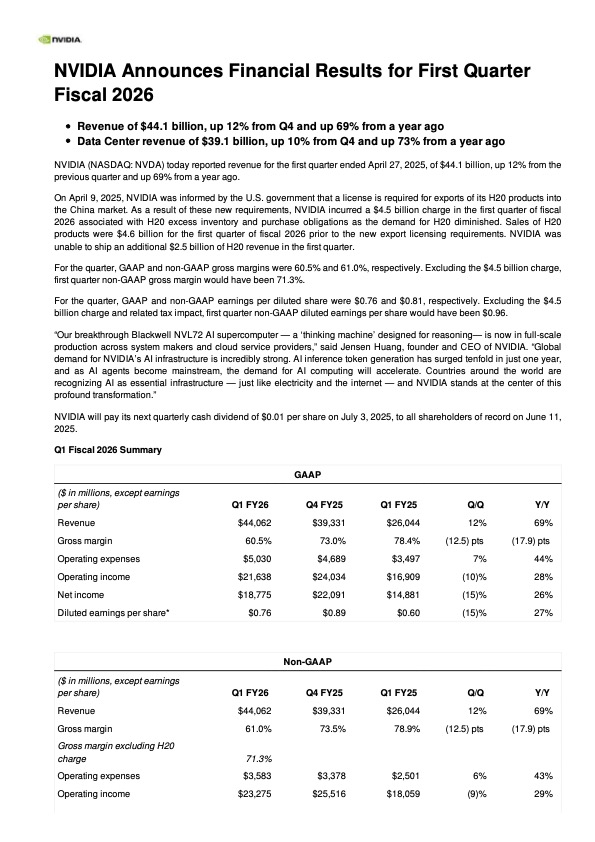

In [15]:
display_vertical_split(image_path="nvidia-first-page.jpg", markdown_text=result)

In [16]:
%%time

image_path = "nvidia-inner-page.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 33.4 s, sys: 27.3 ms, total: 33.4 s
Wall time: 33.3 s


,2025,2025
ASSETS,,
Current assets:,,
"Cash, cash equivalents and marketable securities","$ 53,691","$ 43,210"
"Accounts receivable, net","22,132","23,065"
Inventories,"11,333","10,080"
Prepaid expenses and other current assets,"2,779","3,771"
Total current assets,"89,935","80,126"
"Property and equipment, net","7,136","6,283"
Operating lease assets,"1,810","1,793"
Goodwill,"5,498","5,188"

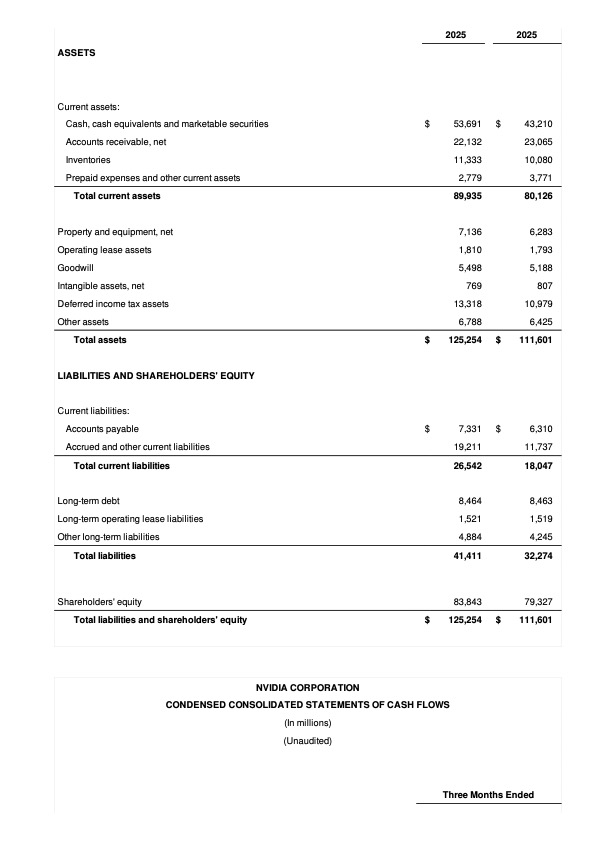

In [17]:
display_vertical_split(image_path="nvidia-inner-page.jpg", markdown_text=result)

In [18]:
%%time

image_path = "receipt.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 20.1 s, sys: 217 ms, total: 20.3 s
Wall time: 20.2 s


Item,Quantity,Description,Price
1 x Cheesy Hash Brown Bites (12),,-Garlic Signature Pot,3.89
,,-Chicken,0.00
,,-Melted Cheese Sauce,0.69
,,-With Plain Fries,0.00
,,-Garlic Signature Pot,0.00
,,-Coke Can,0.10

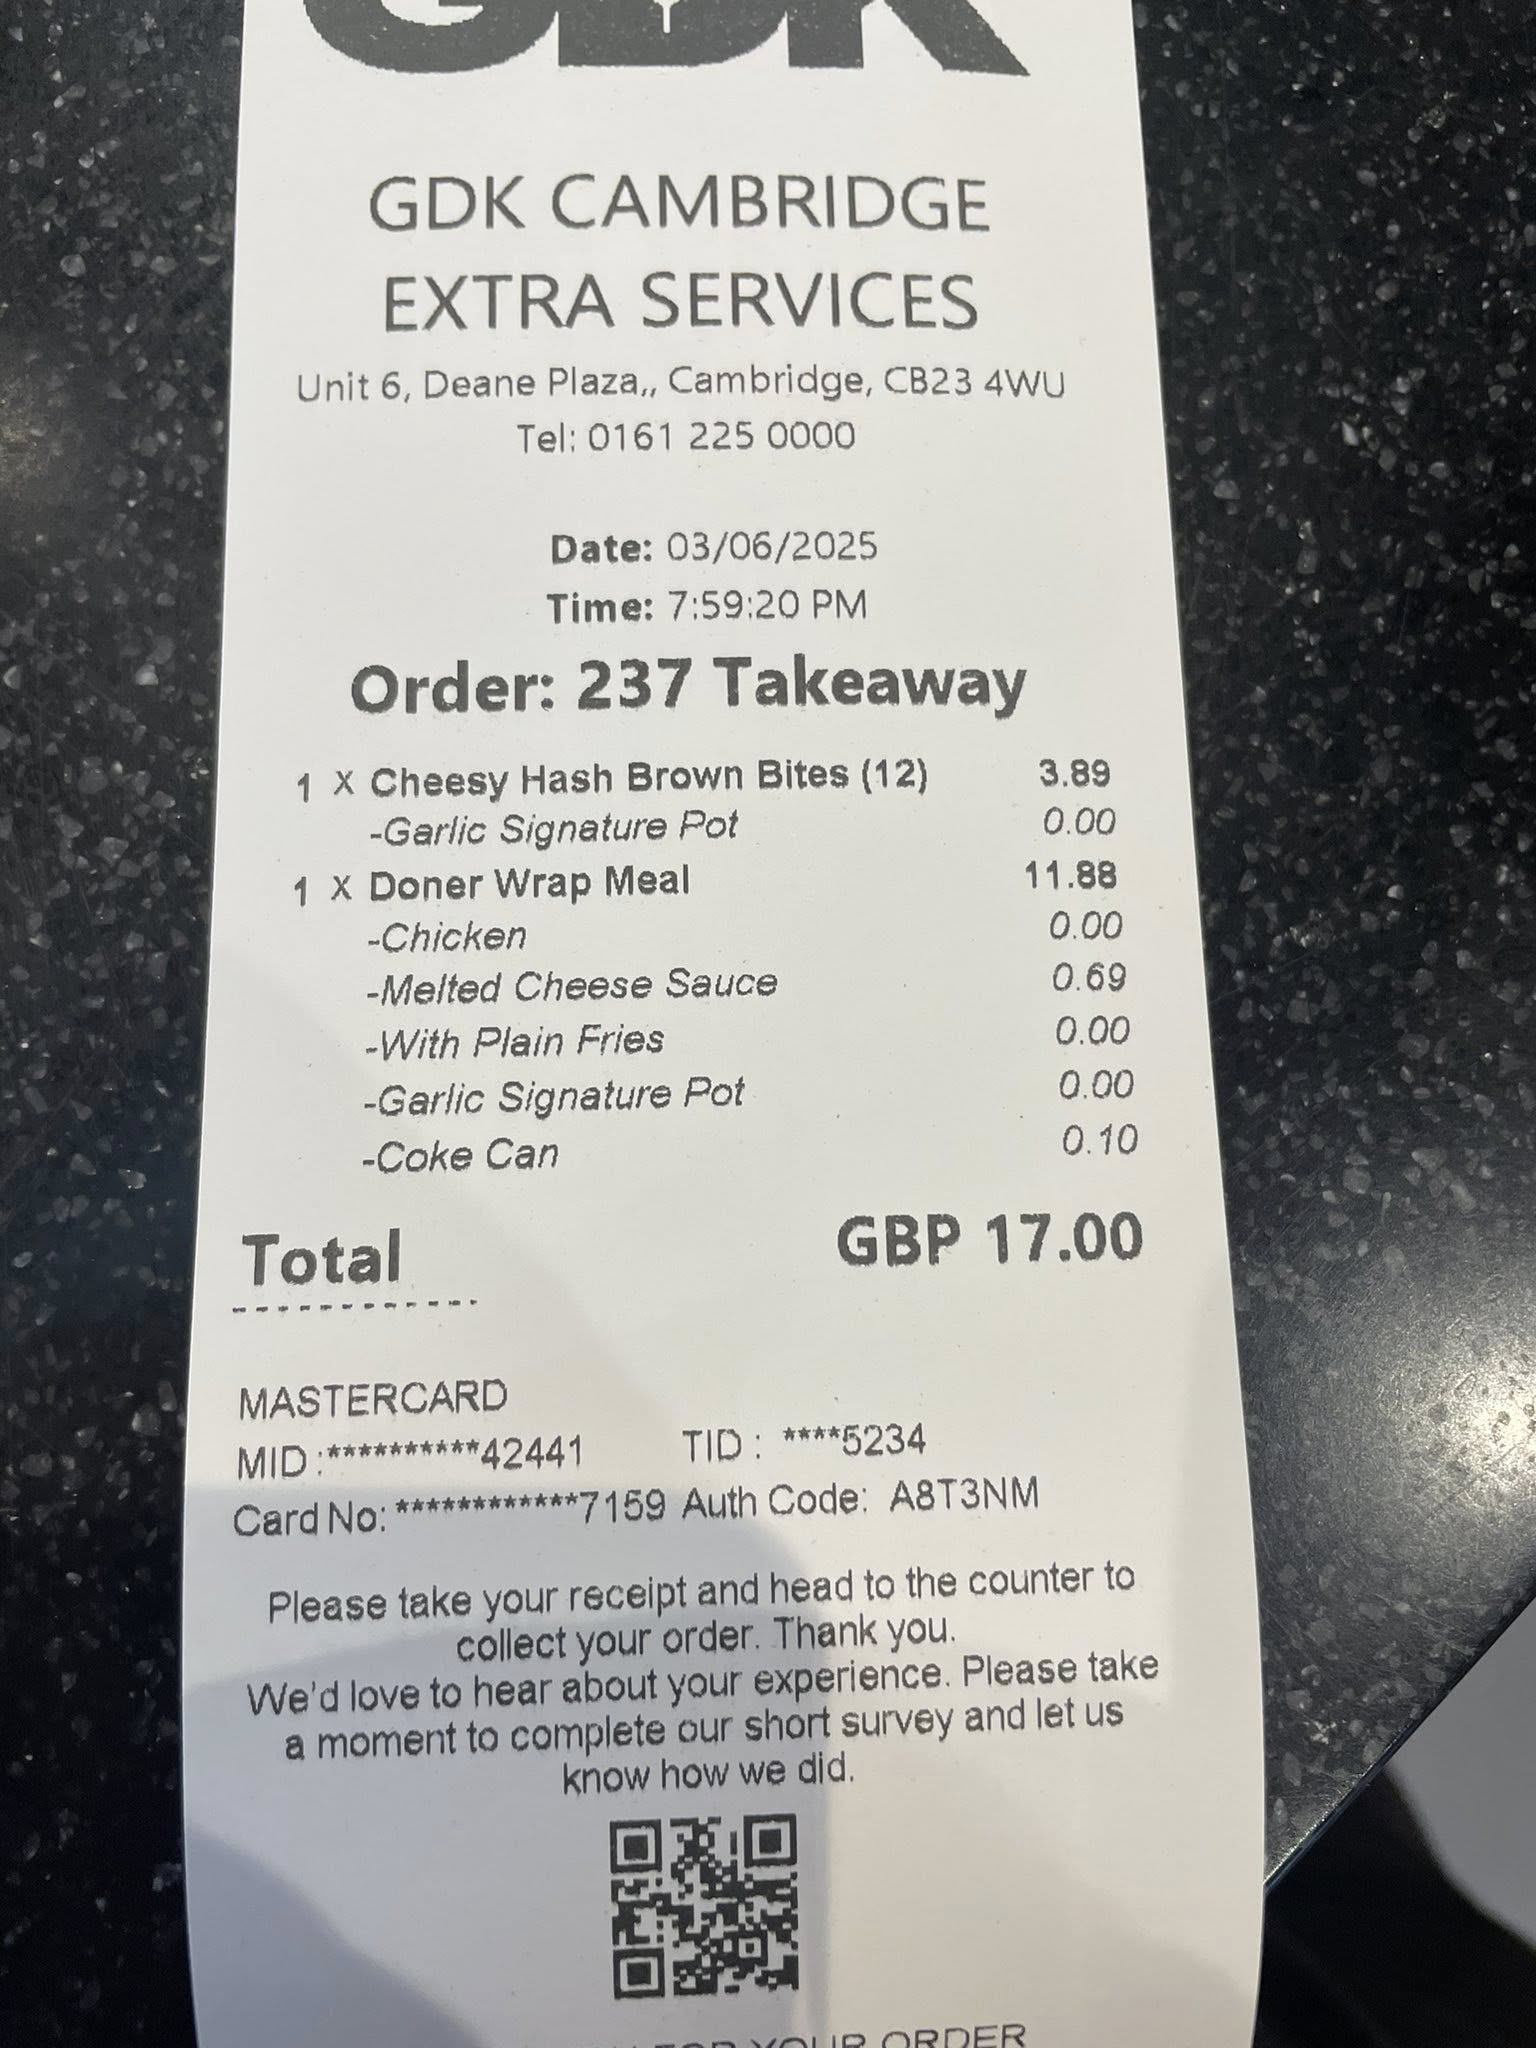

In [19]:
display_vertical_split(image_path="receipt.jpg", markdown_text=result)

In [20]:
%%time

image_path = "id-card.png"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 12.8 s, sys: 13 ms, total: 12.8 s
Wall time: 12.8 s



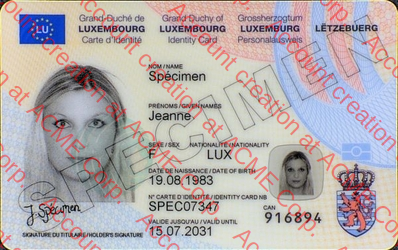

In [21]:
display_vertical_split(image_path="id-card.png", markdown_text=result)